In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Input, Lambda
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.models import Model
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
import warnings
import PIL
import cv2
%matplotlib inline
import seaborn as sns

In [4]:
train_path='/content/gdrive/MyDrive/GWAR_Project/Augmented'
test_path='/content/gdrive/MyDrive/GWAR_Project/Valid'

In [21]:
IMAGE_SIZE = 224

In [22]:
train_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=train_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), classes=['Apple_Healthy', 'Apple_Unhealthy_1', 'Apple_Unhealthy_2', 'Corn_Healthy', 'Corn_Unhealthy_1', 'Corn_Unhealthy_2', 'Tomato_Healthy', 'Tomato_Unhealthy_1', 'Tomato_Unhealthy_2' ], batch_size=32)

test_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=test_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), classes=['Apple_Healthy', 'Apple_Unhealthy_1', 'Apple_Unhealthy_2', 'Corn_Healthy', 'Corn_Unhealthy_1', 'Corn_Unhealthy_2', 'Tomato_Healthy', 'Tomato_Unhealthy_1', 'Tomato_Unhealthy_2'], batch_size=32, shuffle=False)



Found 6426 images belonging to 9 classes.
Found 801 images belonging to 9 classes.


In [23]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

In [24]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
prediction = Dense(len(train_batches.class_indices), activation='softmax')(x)

In [25]:
model = Model(inputs=base_model.input, outputs=prediction)
model.compile(optimizer='Adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94

In [27]:
inception_model = model.fit(
    x=train_batches,
    validation_data=test_batches,
    epochs=10,
    steps_per_epoch=len(train_batches),
    validation_steps=len(test_batches)
)

Epoch 1/10
201/201 [==============================] - 124s 320ms/step - loss: 0.3672 - accuracy: 0.8866 - val_loss: 0.0536 - val_accuracy: 0.9813
Epoch 2/10
201/201 [==============================] - 54s 266ms/step - loss: 0.0354 - accuracy: 0.9904 - val_loss: 0.0308 - val_accuracy: 0.9913
Epoch 3/10
201/201 [==============================] - 55s 271ms/step - loss: 0.0172 - accuracy: 0.9963 - val_loss: 0.0204 - val_accuracy: 0.9938
Epoch 4/10
201/201 [==============================] - 52s 260ms/step - loss: 0.0082 - accuracy: 0.9989 - val_loss: 0.0146 - val_accuracy: 0.9963
Epoch 5/10
201/201 [==============================] - 54s 267ms/step - loss: 0.0129 - accuracy: 0.9970 - val_loss: 0.0174 - val_accuracy: 0.9975
Epoch 6/10
201/201 [==============================] - 54s 270ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0149 - val_accuracy: 0.9950
Epoch 7/10
201/201 [==============================] - 53s 262ms/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.0113 - val_a

In [28]:
score = model.evaluate(test_batches,verbose=0)
print('Test Loss: ',score[0])
print('Test accuracy: ',score[1])
print(score)

Test Loss:  0.010365410707890987
Test accuracy:  0.9975031018257141
[0.010365410707890987, 0.9975031018257141]


26/26 [==============================] - 8s 197ms/step


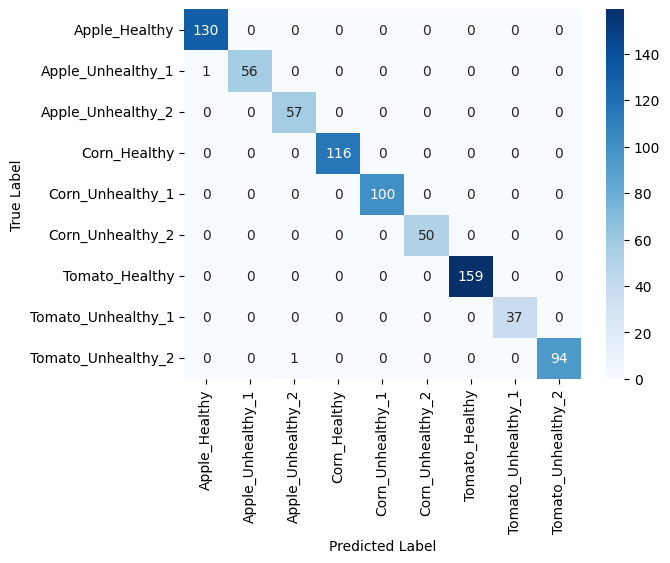

                    precision    recall  f1-score   support

     Apple_Healthy       0.99      1.00      1.00       130
 Apple_Unhealthy_1       1.00      0.98      0.99        57
 Apple_Unhealthy_2       0.98      1.00      0.99        57
      Corn_Healthy       1.00      1.00      1.00       116
  Corn_Unhealthy_1       1.00      1.00      1.00       100
  Corn_Unhealthy_2       1.00      1.00      1.00        50
    Tomato_Healthy       1.00      1.00      1.00       159
Tomato_Unhealthy_1       1.00      1.00      1.00        37
Tomato_Unhealthy_2       1.00      0.99      0.99        95

          accuracy                           1.00       801
         macro avg       1.00      1.00      1.00       801
      weighted avg       1.00      1.00      1.00       801



In [29]:
predictions = model.predict(test_batches, steps=len(test_batches))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys())

conf_mat = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print(classification_report(true_classes, predicted_classes, target_names=class_labels))

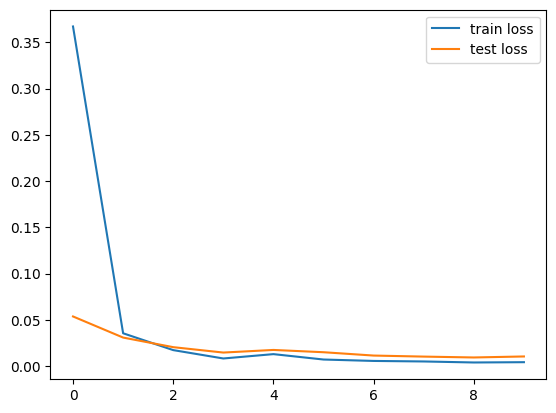

<Figure size 640x480 with 0 Axes>

In [31]:
plt.plot(inception_model.history['loss'], label='train loss')
plt.plot(inception_model.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Train_Test_loss')

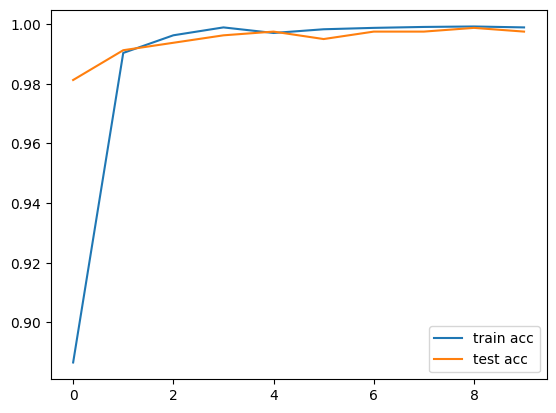

<Figure size 640x480 with 0 Axes>

In [33]:
plt.plot(inception_model.history['accuracy'], label='train acc')
plt.plot(inception_model.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()
plt.savefig('Train_Test_acc')